**02_knn_with_scaling_and_onehot.ipynb**
- Goal: KNN with simple feature engineering (scaling numeric features + one-hot encoding categorical features)
- Load CSV
- Build numeric and categorical feature lists
- Simple imputation (median/mode)
- StandardScaler for numeric
- OneHotEncoder for categoricals (no Pipeline, we do it step-by-step to keep it simple)
- Train/test split
- Fit KNN and evaluate

In [1]:
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from pathlib import Path
import sys
# Point to the project root (adjust parents[1] to parents[2] if notebook is deeper)
PROJECT_ROOT = Path.cwd().resolve().parent
sys.path.insert(0, str(PROJECT_ROOT))

# <-- Imports custom preprocessing functions from 'functions.py' <-- #

from lib.feature_engineering import (engineer_features)

# <-- Loads YAML configuration to dynamically reference CSV output files. <-- #

config = None  # <-- Initialize config
try:
    with open("../config.yaml", "r") as file:
        config = yaml.safe_load(file)
except:
    print("Yaml configuration file not found!")

In [2]:
# 1) Load the dataset
df_fraud_dataset = pd.read_csv(config['input_data']['file1'])
kept_numeric_cols_df = pd.read_csv(config['output_data']['file2'])

print("\ndf_fraud_dataset Shape:", df_fraud_dataset.shape)
print("Columns:", df_fraud_dataset.columns.tolist())
display(df_fraud_dataset.head(3))


df_fraud_dataset Shape: (50000, 21)
Columns: ['Transaction_ID', 'User_ID', 'Transaction_Amount', 'Transaction_Type', 'Timestamp', 'Account_Balance', 'Device_Type', 'Location', 'Merchant_Category', 'IP_Address_Flag', 'Previous_Fraudulent_Activity', 'Daily_Transaction_Count', 'Avg_Transaction_Amount_7d', 'Failed_Transaction_Count_7d', 'Card_Type', 'Card_Age', 'Transaction_Distance', 'Authentication_Method', 'Risk_Score', 'Is_Weekend', 'Fraud_Label']


,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Timestamp,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,...,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Type,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label
0,TXN_33553,USER_1834,39.79,POS,2023-08-14 19:30:00,93213.17,Laptop,Sydney,Travel,0,...,7,437.63,3,Amex,65,883.17,Biometric,0.8494,0,0
1,TXN_9427,USER_7875,1.19,Bank Transfer,2023-06-07 04:01:00,75725.25,Mobile,New York,Clothing,0,...,13,478.76,4,Mastercard,186,2203.36,Password,0.0959,0,1
2,TXN_199,USER_2734,28.96,Online,2023-06-20 15:25:00,1588.96,Tablet,Mumbai,Restaurants,0,...,14,50.01,4,Visa,226,1909.29,Biometric,0.8400,0,1


In [3]:
# 2) Target
target_col = "Fraud_Label"
assert target_col in df_fraud_dataset.columns, "Target column Fraud_Label not found."

In [4]:
# 3) Optional: if Timestamp exists, create hour/day-of-week (simple time features)
if "Timestamp" in df_fraud_dataset.columns:
    df_fraud_dataset["Timestamp"] = pd.to_datetime(df_fraud_dataset["Timestamp"], errors="coerce")
    df_fraud_dataset["tx_hour"] = df_fraud_dataset["Timestamp"].dt.hour
    df_fraud_dataset["tx_dow"] = df_fraud_dataset["Timestamp"].dt.day_name()
    
display(df_fraud_dataset[['Timestamp', "tx_hour", "tx_dow"]])

,Timestamp,tx_hour,tx_dow
0,2023-08-14 19:30:00,19,Monday
1,2023-06-07 04:01:00,4,Wednesday
2,2023-06-20 15:25:00,15,Tuesday
3,2023-12-07 00:31:00,0,Thursday
4,2023-11-11 23:44:00,23,Saturday
...,...,...,...
49995,2023-01-29 18:38:00,18,Sunday
49996,2023-05-09 08:55:00,8,Tuesday
49997,2023-01-30 19:32:00,19,Monday
49998,2023-03-09 19:47:00,19,Thursday


In [5]:
kept_numeric_cols_list = kept_numeric_cols_df["kept_numeric_features"].tolist()

print("Numeric columns to use from filter_numeric_ttest_vif:", kept_numeric_cols_list[:10], " ... total:", len(kept_numeric_cols_list))

cat_cols_list = df_fraud_dataset.select_dtypes(include='object').columns.tolist()
print("\nCategorical columns to use:", cat_cols_list[:10], " ... total:", len(cat_cols_list))

Numeric columns to use from filter_numeric_ttest_vif: ['Failed_Transaction_Count_7d', 'Risk_Score']  ... total: 2

Categorical columns to use: ['Transaction_ID', 'User_ID', 'Transaction_Type', 'Device_Type', 'Location', 'Merchant_Category', 'Card_Type', 'Authentication_Method', 'tx_dow']  ... total: 9


In [6]:
# 4) Choose numeric and categorical features (keep it small and clear)
candidate_numeric = (
    kept_numeric_cols_list  # only if they exist; we'll filter below
)

candidate_categorical = [
    "Transaction_Type", "Device_Type", "Location", "Merchant_Category", "Card_Type", "Authentication_Method" # only if they exist; we'll filter below
]

num_cols = [c for c in candidate_numeric if c in df_fraud_dataset.columns]
cat_cols = [c for c in candidate_categorical if c in df_fraud_dataset.columns]

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

Numeric columns: ['Failed_Transaction_Count_7d', 'Risk_Score']
Categorical columns: ['Transaction_Type', 'Device_Type', 'Location', 'Merchant_Category', 'Card_Type', 'Authentication_Method']


In [7]:
# 5) Drop rows where target is missing (just to be safe)
df_fraud_dataset = df_fraud_dataset.dropna(subset=[target_col]).copy()
y = df_fraud_dataset[target_col].astype(int)

In [8]:
# 6) Build numeric matrix
X_num = df_fraud_dataset[num_cols].copy()

# Simple numeric imputation: fill missing values with median
num_imputer = SimpleImputer(strategy="median")
X_num_imputed = num_imputer.fit_transform(X_num)

# Scale numeric features (KNN cares about distances, so scaling helps)
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num_imputed)

In [9]:
# 7) Build categorical matrix
# Use OneHotEncoder to convert categories to 0/1 columns.
if len(cat_cols) > 0:
    X_cat = df_fraud_dataset[cat_cols].astype(str).copy()
    cat_imputer = SimpleImputer(strategy="most_frequent")
    X_cat_imputed = cat_imputer.fit_transform(X_cat)

    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    X_cat_ohe = ohe.fit_transform(X_cat_imputed)
else:
    # If there are no categorical columns available, just create empty array
    X_cat_ohe = np.empty((len(df_fraud_dataset), 0))

In [10]:
# 8) Combine numeric and categorical
# np.hstack stacks arrays side-by-side
X_all = np.hstack([X_num_scaled, X_cat_ohe])
print("Final feature matrix shape:", X_all.shape)

Final feature matrix shape: (50000, 27)


In [11]:
# 9) (Optional) small stratified sample for speed if your dataset is very big
# Here we keep it simple and train on everything; uncomment if needed:
# from sklearn.utils import resample
# # Example: take 6000 rows keeping class balance approximately
# sample_size = 6000
# if len(y) > sample_size:
#     strat_idx = (df[[target_col]]
#                  .assign(idx=np.arange(len(df)))
#                  .groupby(target_col, group_keys=False)
#                  .apply(lambda x: x.sample(frac=sample_size/len(df), random_state=42)))["idx"].values
#     X_all = X_all[strat_idx]
#     y = y.iloc[strat_idx].reset_index(drop=True)

In [12]:
# 10) Train/Test split (stratify keeps the same fraud ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y, test_size=0.20, random_state=42, stratify=y
)

print("Train:", X_train.shape, " Test:", X_test.shape)
print("Fraud rate train:", y_train.mean(), " Fraud rate test:", y_test.mean())

Train: (40000, 27)  Test: (10000, 27)
Fraud rate train: 0.32135  Fraud rate test: 0.3213


In [13]:
# 11) KNN model (start with k=25; try 5, 10, 15, 25, etc.)
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train, y_train)

,n_neighbors,25
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [14]:
# 12) Predictions and evaluation
y_pred = knn.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Accuracy:", round(acc, 4))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9218

Classification report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94      6787
           1       0.96      0.79      0.87      3213

    accuracy                           0.92     10000
   macro avg       0.93      0.89      0.91     10000
weighted avg       0.92      0.92      0.92     10000

Confusion matrix:
 [[6672  115]
 [ 667 2546]]


In [18]:
# DROP-IN REPLACEMENT CELL (fixes the import typo and computes AUC metrics)

from sklearn.metrics import (
    roc_curve,
    precision_recall_curve,
    roc_auc_score,
    average_precision_score  # <-- correct name
)

# Safety: ensure the model can output probabilities
assert hasattr(knn, "predict_proba"), "This classifier has no predict_proba(). Use a model that supports probabilities."

# Probability of the positive class (Fraud = 1)
y_proba = knn.predict_proba(X_test)[:, 1]

# Quick score summary
roc_auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)
print("ROC-AUC:", round(roc_auc, 4))
print("PR-AUC:", round(pr_auc, 4))

# If you also want the curve points for plotting later:
fpr, tpr, _ = roc_curve(y_test, y_proba)
prec, rec, _ = precision_recall_curve(y_test, y_proba)
# (plotting can be done in a separate cell)

ROC-AUC: 0.9852
PR-AUC: 0.9618


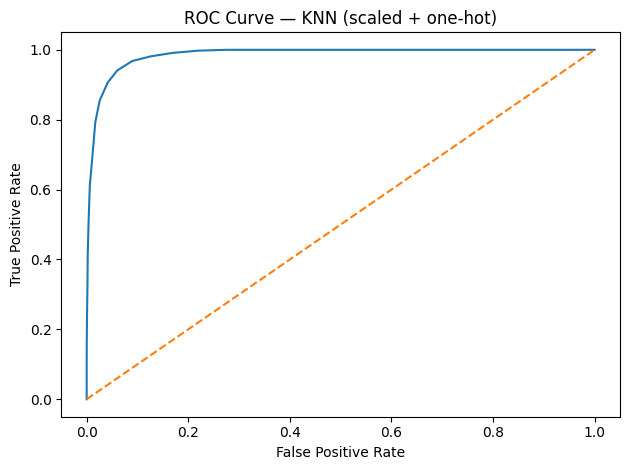

In [22]:
# ----------------------------------------------
# Cell B — ROC Curve (generate and save)
# ----------------------------------------------
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--') # diagonal reference
plt.title('ROC Curve — KNN (scaled + one-hot)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.tight_layout()

# Save chart (change path if you prefer)
roc_path = 'roc_curve_knn.png'
# plt.savefig(roc_path, dpi=120, bbox_inches='tight')
plt.show()
# print('Saved:', roc_path)

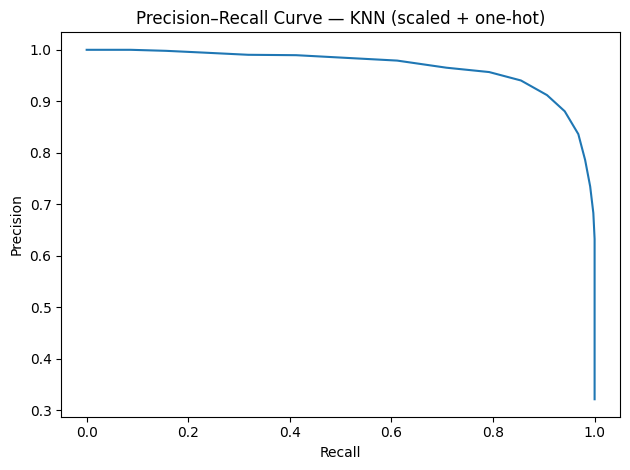

In [24]:
# ----------------------------------------------
# Cell C — Precision–Recall Curve (generate and save)
# ----------------------------------------------
prec, rec, _ = precision_recall_curve(y_test, y_proba)

plt.figure()
plt.plot(rec, prec)
plt.title('Precision–Recall Curve — KNN (scaled + one-hot)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.tight_layout()

# Save chart (change path if you prefer)
# pr_path = 'precision_recall_curve_knn.png'
# plt.savefig(pr_path, dpi=120, bbox_inches='tight')
plt.show()
# print('Saved:', pr_path)

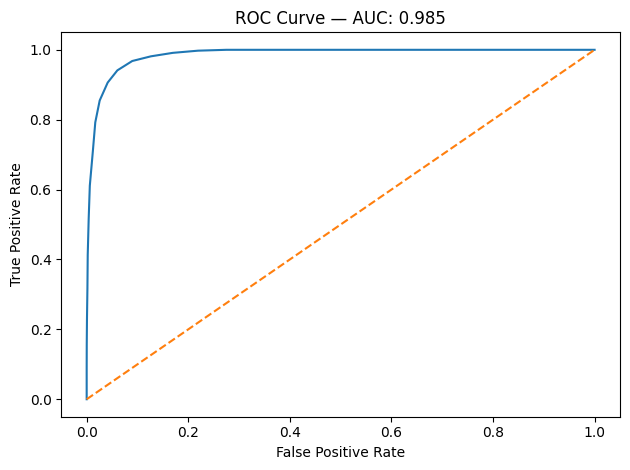

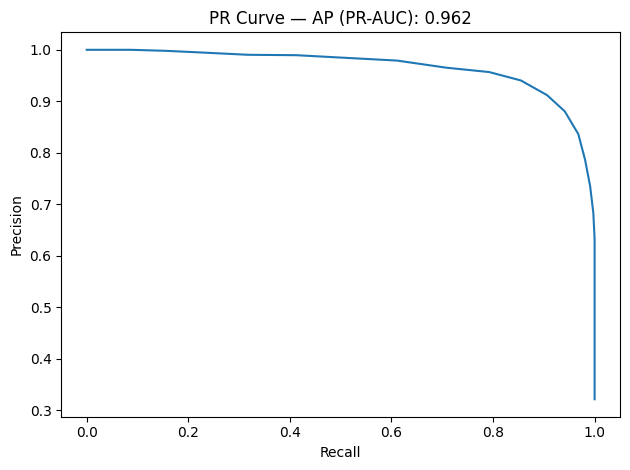

In [28]:
# ----------------------------------------------
# (Optional) Cell D — Add curve annotations with AUC values
# ----------------------------------------------
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title(f'ROC Curve — AUC: {roc_auc:.3f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.tight_layout()
# plt.savefig('roc_curve_knn_with_auc.png', dpi=120, bbox_inches='tight')
plt.show()


plt.figure()
plt.plot(rec, prec)
plt.title(f'PR Curve — AP (PR-AUC): {pr_auc:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.tight_layout()
# plt.savefig('precision_recall_curve_knn_with_auc.png', dpi=120, bbox_inches='tight')
plt.show()

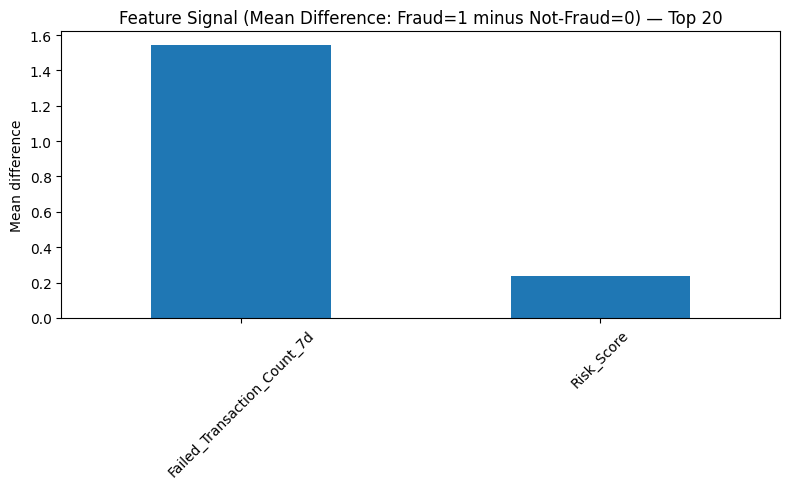

In [29]:
# ==============================================
# Cell 1 — Simple "importance" (class-mean difference) bar chart
# Use when you want a quick, beginner-friendly signal of which NUMERIC features differ
# between Fraud=1 and Not-Fraud=0. This is NOT model-based; it’s a simple reference.
# Requires: df (original dataframe), target_col, and a list of numeric columns (num_cols)
# ==============================================

# Compute mean difference by class (Fraud=1 minus Not-Fraud=0)
means_1 = df_fraud_dataset[df_fraud_dataset[target_col] == 1][num_cols].mean(numeric_only=True)
means_0 = df_fraud_dataset[df_fraud_dataset[target_col] == 0][num_cols].mean(numeric_only=True)
mean_diff = (means_1 - means_0).sort_values(key=lambda s: np.abs(s), ascending=False)


plt.figure(figsize=(8, 5))
mean_diff.head(20).plot(kind='bar') # show top 20 absolute differences
plt.xticks(rotation=45)
plt.title('Feature Signal (Mean Difference: Fraud=1 minus Not-Fraud=0) — Top 20')
plt.ylabel('Mean difference')
plt.tight_layout()
# plt.savefig('feature_signal_mean_diff_top20.png', dpi=120, bbox_inches='tight')
plt.show()
# print('Saved: feature_signal_mean_diff_top20.png')

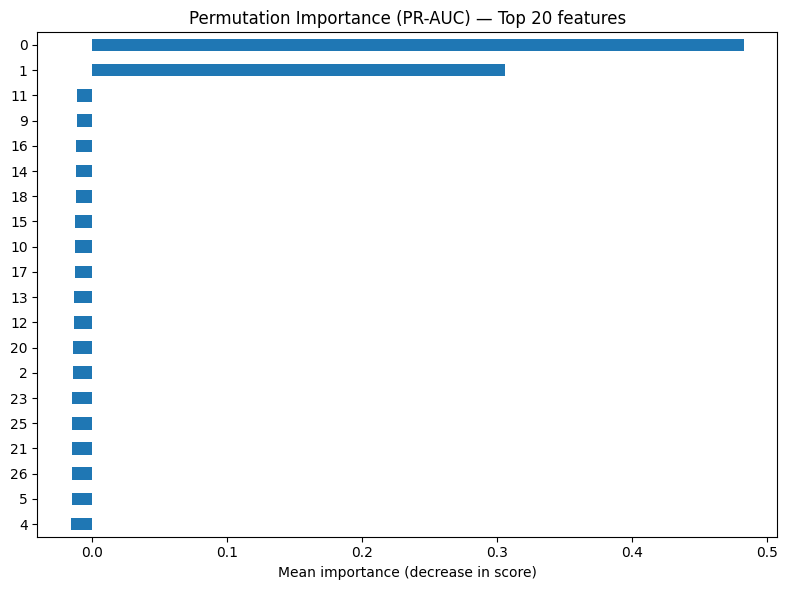

In [32]:
# ==============================================
# Cell 2 — Permutation Importance (model-based) bar chart for your fitted KNN
# This works with any fitted classifier that implements .predict (KNN does).
# We compute importance on the TEST set and plot the top 20 features.
# NOTE: For KNN with many features/rows, this can be slow. Keep n_repeats small.
# Requires: knn (fitted), X_test, y_test, and feature names for the transformed matrix.
# ==============================================

from sklearn.inspection import permutation_importance

feature_names = None
try:
    # Numeric
    num_names = num_cols.copy()
    # Categorical: try to get from OneHotEncoder (ohe) if available
    if 'ohe' in globals():
        # Passing original column names to fit, this returns readable names
        try:
            cat_names = ohe.get_feature_names_out(input_features=cat_cols)
        except TypeError:
            # Older sklearn
            num_names = ohe.get_feature_names_out()
            feature_names = list(num_names) + list(cat_names)
    else:
        feature_names = list(num_names)
except Exception:
    # Fallback: anonymous feature names
    feature_names = [f'f_{i}' for i in range(X_test.shape[1])]


# Permutation importance
# scoring can be 'average_precision' for PR-AUC focus; use 'roc_auc' if preferred
result = permutation_importance(
knn, X_test, y_test, scoring='average_precision', n_repeats=5, random_state=42, n_jobs=1
)
importances = pd.Series(result.importances_mean, index=feature_names)


imp_sorted = importances.sort_values(ascending=False)
plt.figure(figsize=(8, 6))
imp_sorted.head(20).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Permutation Importance (PR-AUC) — Top 20 features')
plt.xlabel('Mean importance (decrease in score)')
plt.tight_layout()
# plt.savefig('permutation_importance_top20.png', dpi=120, bbox_inches='tight')
plt.show()
# print('Saved: permutation_importance_top20.png')

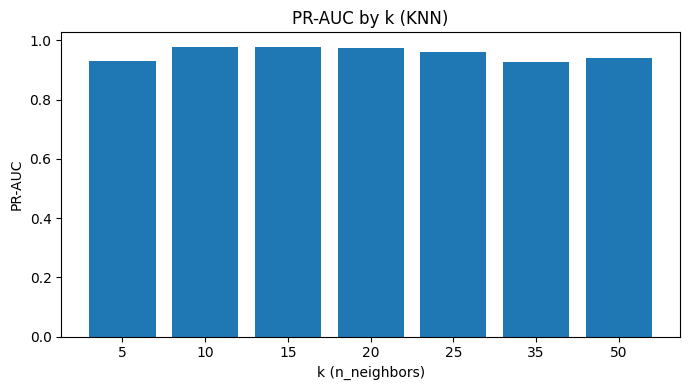

In [35]:
# ==============================================
# Cell 3 — Small bar chart of PR-AUC by k (KNN hyperparameter sweep)
# Requires: X_train, X_test, y_train, y_test (already prepared in your 02 notebook)
# This cell trains several KNNs with different k values and plots PR-AUC for each.
# ==============================================

k_list = [5, 10, 15, 20, 25, 35, 50]
pr_scores = []

for k in k_list:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    y_proba_k = model.predict_proba(X_test)[:, 1]
    pr_auc_k = average_precision_score(y_test, y_proba_k)
    pr_scores.append(pr_auc_k)

# Plot PR-AUC by k
plt.figure(figsize=(7, 4))
plt.bar([str(k) for k in k_list], pr_scores)
plt.title('PR-AUC by k (KNN)')
plt.xlabel('k (n_neighbors)')
plt.ylabel('PR-AUC')
plt.tight_layout()
# plt.savefig('pr_auc_by_k.png', dpi=120, bbox_inches='tight')
plt.show()
# print('Saved: pr_auc_by_k.png')